# Restricted Boltzmann Machine for Classification using NumPy
## Authors: Arun Chandra Bhusal (078BEI049), Gunaraj Khatri (078BEI016), Manorath Bhatt (078BEI021)

#### This notebook implements an RBM using only NumPy, trained on the MNIST handwritten digits and Fashion MNIST datasets.
#### RBM is a generative stochastic neural network that learns to model input data distributions.
#### We use Contrastive Divergence (CD-k) to train and visualize learned features.

#### It makes use of two popular datasets: MNIST for handwritten numbers and Fashion-MNIST for dress images


In [ ]:

import os
import time
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, List
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import pickle
np.random.seed(42)

plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["axes.grid"] = True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



## Data Loading

From `tensorflow.keras.datasets` (MNIST and Fashion-MNIST)


In [ ]:
def _binarize(X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    X = X.astype(np.float32)
    if X.max() > 1.0:
        X = X / 255.0
    return (X > threshold).astype(np.float32)

def _one_hot(y: np.ndarray, n_classes: int) -> np.ndarray:
    y = y.astype(int).ravel()
    oh = np.zeros((y.shape[0], n_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def _load_mnist_tf(fashion: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    from tensorflow.keras.datasets import mnist, fashion_mnist
    if fashion:
        (x_tr, y_tr), (x_te, y_te) = fashion_mnist.load_data()
    else:
        (x_tr, y_tr), (x_te, y_te) = mnist.load_data()
    x = np.concatenate([x_tr, x_te], axis=0).reshape(-1, 28*28)
    y = np.concatenate([y_tr, y_te], axis=0)
    return x, y

def load_dataset(fashion: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Load MNIST or Fashion-MNIST as (X, y)."""
    try:
        return _load_mnist_tf(fashion=fashion)
    except Exception as e:
        print("[WARN] Loading from TensorFlow failed:", e)



## RBM Implementation (Bernoulli–Bernoulli)

- Visible units: 784 pixels + 10 label units
- Hidden units: tunable
- Training: Contrastive Divergence (CD-k) with momentum and decay
- Classification: free energy with clamped label candidates


In [ ]:
def sigmoid(x):
    x = np.array(x, dtype=np.float64)
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

@dataclass
class RBMConfig:
    n_visible: int
    n_hidden: int = 128
    learning_rate: float = 0.1
    k: int = 1
    batch_size: int = 128
    momentum: float = 0.5
    weight_decay: float = 1e-4
    epochs: int = 10
    seed: int = 42

class RBM:
    def __init__(self, cfg: RBMConfig):
        rng = np.random.RandomState(cfg.seed)
        self.cfg = cfg
        self.W = 0.01 * rng.randn(cfg.n_visible, cfg.n_hidden).astype(np.float32)
        self.b = np.zeros(cfg.n_visible, dtype=np.float32)  # visible bias
        self.c = np.zeros(cfg.n_hidden, dtype=np.float32)   # hidden bias
        # velocities for momentum
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)
        self.vc = np.zeros_like(self.c)

    # conditional probabilities
    def _p_h_given_v(self, v):
        return sigmoid(v @ self.W + self.c)

    def _p_v_given_h(self, h):
        return sigmoid(h @ self.W.T + self.b)

    def _sample_bernoulli(self, p):
        return (np.random.rand(*p.shape) < p).astype(np.float32)

    def contrastive_divergence(self, v0):
        cfg = self.cfg
        # positive phase
        ph0 = self._p_h_given_v(v0)
        h0 = self._sample_bernoulli(ph0)

        # negative phase
        vk = v0.copy()
        hk = h0
        for _ in range(cfg.k):
            pvk = self._p_v_given_h(hk)
            vk = self._sample_bernoulli(pvk)
            phk = self._p_h_given_v(vk)
            hk = self._sample_bernoulli(phk)

        phk = self._p_h_given_v(vk)

        # gradients
        bs = v0.shape[0]
        pos = v0.T @ ph0
        neg = vk.T @ phk
        dW = (pos - neg) / bs - cfg.weight_decay * self.W
        db = (v0 - vk).mean(axis=0)
        dc = (ph0 - phk).mean(axis=0)

        # momentum update
        self.vW = cfg.momentum * self.vW + cfg.learning_rate * dW
        self.vb = cfg.momentum * self.vb + cfg.learning_rate * db
        self.vc = cfg.momentum * self.vc + cfg.learning_rate * dc

        self.W += self.vW
        self.b += self.vb
        self.c += self.vc

        # reconstruction error on pixels only
        return ((v0[:, :-10] - vk[:, :-10]) ** 2).mean()

    def free_energy(self, v):
        # F(v) = -b^T v - sum_j log(1 + exp(c_j + W_j^T v))
        linear = v @ self.W + self.c
        hidden_term = np.logaddexp(0, linear).sum(axis=1)
        vbias_term = v @ self.b
        return -vbias_term - hidden_term

    def predict_labels(self, X_pixels):
        B = X_pixels.shape[0]
        n_classes = 10

        X_rep = np.repeat(X_pixels, n_classes, axis=0)
        labels = np.tile(np.eye(n_classes, dtype=np.float32), (B, 1))
        V = np.hstack([X_rep, labels])
        energies = self.free_energy(V).reshape(B, n_classes)
        preds = np.argmin(energies, axis=1)
        return preds

    def fit(self, X_pixels, y, y_onehot, epochs=None, verbose=True):
        cfg = self.cfg
        epochs = epochs or cfg.epochs
        n = X_pixels.shape[0]
        idx = np.arange(n)

        history = {
            "recon_mse": [],
        }

        for ep in range(epochs):
            np.random.shuffle(idx)
            recon_epoch = []
            for i in range(0, n, cfg.batch_size):
                sel = idx[i:i+cfg.batch_size]
                pixels_b = X_pixels[sel]
                labels_b = y_onehot[sel]
                v0 = np.hstack([pixels_b, labels_b]).astype(np.float32)
                mse = self.contrastive_divergence(v0)
                recon_epoch.append(mse)
            history["recon_mse"].append(np.mean(recon_epoch))
            if verbose:
                print(f"Epoch {ep+1:02d} | recon MSE {history['recon_mse'][-1]:.5f}")
        return history



## Training and Evaluation

- Split into train/val
- Train RBM with labels appended and clamped in the visible layer during positive phase
- Evaluate classification via free energy on validation set


In [ ]:

def run_single_experiment(dataset_name: str,
                          fashion: bool,
                          n_samples: int,
                          test_size: float,
                          cfg_overrides: Dict) -> Dict:
    # Load data
    X, y = load_dataset(fashion=fashion)
    X = X[:n_samples]
    y = y[:n_samples]
    X = _binarize(X, threshold=0.5)
    y = y.astype(int)
    y_oh = _one_hot(y, 10)

    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    y1_tr = _one_hot(y_tr, 10)
    y1_val = _one_hot(y_val, 10)

    n_visible = X.shape[1] + 10
    cfg = RBMConfig(n_visible=n_visible)
    for k, v in cfg_overrides.items():
        setattr(cfg, k, v)

    rbm = RBM(cfg)

    t0 = time.time()
    hist = rbm.fit(X_tr, y_tr, y1_tr, epochs=cfg.epochs, verbose=False)
    train_time = time.time() - t0

    # Evaluate
    y_pred = rbm.predict_labels(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_val, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    result = dict(
        dataset=dataset_name,
        n_hidden=cfg.n_hidden,
        k=cfg.k,
        lr=cfg.learning_rate,
        batch_size=cfg.batch_size,
        momentum=cfg.momentum,
        weight_decay=cfg.weight_decay,
        epochs=cfg.epochs,
        n_samples=n_samples,
        val_acc=acc,
        val_prec=prec,
        val_rec=rec,
        val_f1=f1,
        train_time_sec=train_time,
        recon_mse_last=float(hist["recon_mse"][-1]) if hist["recon_mse"] else float("nan"),
    )
    return result, rbm



## Hyperparameter Sweep

Small grid intended to finish quickly:
- `n_hidden`: [64, 128, 256]
- `k` (CD steps): [1, 3]
- `learning_rate`: [0.05, 0.1]
- epochs: 8


In [ ]:

GRID = {
    "n_hidden": [64, 128, 256],
    "k": [1, 3, 5],
    "learning_rate": [0.05, 0.1, 0.2],
}
DEFAULTS = dict(
    batch_size=128,
    momentum=0.5,
    weight_decay=1e-4,
    epochs=8,
    seed=42,
)
DATASETS = [
    ("MNIST", False),
    ("Fashion-MNIST", True),
]

def run_sweep(n_samples=20000, test_size=0.2):
    results = []
    best_models = {}
    for name, is_fashion in DATASETS:
        best_acc = -1.0
        best_cfg = None
        best_rbm = None
        for n_hidden in GRID["n_hidden"]:
            for k in GRID["k"]:
                for lr in GRID["learning_rate"]:
                    cfg = dict(DEFAULTS)
                    cfg.update(dict(n_hidden=n_hidden, k=k, learning_rate=lr, n_visible=784+10))
                    start_time = time.time()
                    print(f"[{name}] n_hidden={n_hidden} k={k} lr={lr} | started at {datetime.now().strftime('%H:%M:%S')}")
                    res, rbm = run_single_experiment(name, is_fashion, n_samples, test_size, cfg)
                    results.append(res)
                    end_time = time.time()
                    elapsed = end_time - start_time
                    print(f"Completed at {datetime.now().strftime('%H:%M:%S')} | took {elapsed:.2f} seconds")
                    if res["val_acc"] > best_acc:
                        best_acc = res["val_acc"]
                        best_cfg = cfg
                        best_rbm = rbm
        # Save the best model for this dataset
        save_path = f"/content/drive/MyDrive/best_rbm_{name}_acc{best_acc:.4f}.pkl"
        with open(save_path, "wb") as f:
            pickle.dump(best_rbm, f)
        print(f"Saved best model for {name} to {save_path} (val_acc={best_acc:.4f})")
        best_models[name] = (best_cfg, best_rbm, best_acc)
    df = pd.DataFrame(results)
    return df, best_models



### Runing the sweep


In [ ]:
df_results, best_models = run_sweep(n_samples=20000, test_size=0.2)
df_results.to_csv("rbm_sweep_results.csv", index=False)
df_results


[MNIST] n_hidden=64 k=1 lr=0.05 | started at 07:28:12
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Completed at 07:28:33 | took 20.80 seconds
[MNIST] n_hidden=64 k=1 lr=0.1 | started at 07:28:33
Completed at 07:28:52 | took 19.61 seconds
[MNIST] n_hidden=64 k=1 lr=0.2 | started at 07:28:52
Completed at 07:29:16 | took 23.51 seconds
[MNIST] n_hidden=64 k=3 lr=0.05 | started at 07:29:16
Completed at 07:30:14 | took 58.53 seconds
[MNIST] n_hidden=64 k=3 lr=0.1 | started at 07:30:14
Completed at 07:31:13 | took 59.13 seconds
[MNIST] n_hidden=64 k=3 lr=0.2 | started at 07:31:13
Completed at 07:32:28 | took 75.09 seconds
[MNIST] n_hidden=64 k=5 lr=0.05 | started at 07:32:28
Completed at 07:33:39 | took 70.77 seconds
[MNIST] n_hidden=64 k=5 lr=0.1 | started at 07:33:39
Completed at 07:35:11 | took 91.51 seconds
[MNIST] n_hidden=64 k=5 lr=0.2 | started at 07:35:11
Completed at 07:36:19 | took 68.08 seconds
[MNIST] n_hidden=128 k=1 lr=0.05 | started at 07:36:19
Completed at 07:37:00 | too

,dataset,n_hidden,k,lr,batch_size,momentum,weight_decay,epochs,n_samples,val_acc,val_prec,val_rec,val_f1,train_time_sec,recon_mse_last
0,MNIST,64,1,0.05,128,0.5,0.0001,8,20000,0.85875,0.858576,0.855604,0.855818,18.987190,0.092391
1,MNIST,64,1,0.10,128,0.5,0.0001,8,20000,0.87150,0.870792,0.869763,0.869704,18.805992,0.082280
2,MNIST,64,1,0.20,128,0.5,0.0001,8,20000,0.86950,0.870658,0.867135,0.867661,22.712465,0.078117
3,MNIST,64,3,0.05,128,0.5,0.0001,8,20000,0.85775,0.858138,0.853890,0.853575,57.527131,0.101746
4,MNIST,64,3,0.10,128,0.5,0.0001,8,20000,0.87825,0.879244,0.876349,0.876960,58.102788,0.091528
5,MNIST,64,3,0.20,128,0.5,0.0001,8,20000,0.85350,0.853442,0.850464,0.850707,74.302856,0.092689
6,MNIST,64,5,0.05,128,0.5,0.0001,8,20000,0.86225,0.863915,0.859051,0.859797,69.745552,0.106099
7,MNIST,64,5,0.10,128,0.5,0.0001,8,20000,0.86950,0.868777,0.867169,0.867307,90.559252,0.096897
8,MNIST,64,5,0.20,128,0.5,0.0001,8,20000,0.86500,0.864189,0.862439,0.862469,67.161561,0.096387
9,MNIST,128,1,0.05,128,0.5,0.0001,8,20000,0.87700,0.878842,0.874644,0.875128,40.290448,0.077959



## Plots

Aggregate mean validation accuracy across other parameters for each factor.


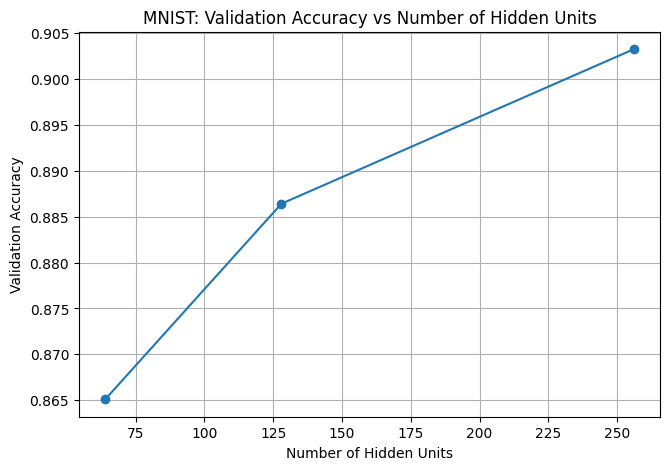

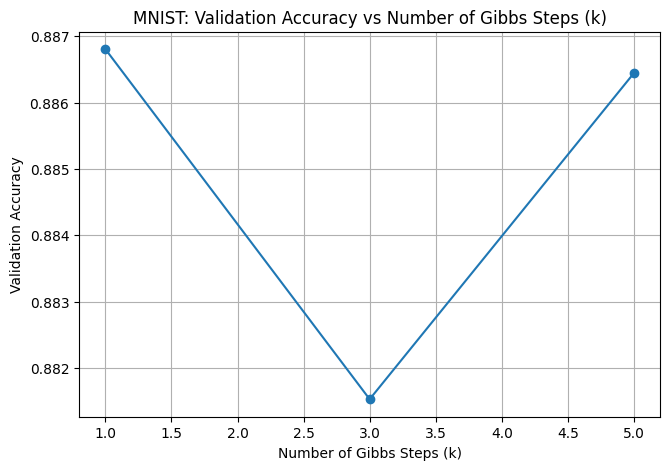

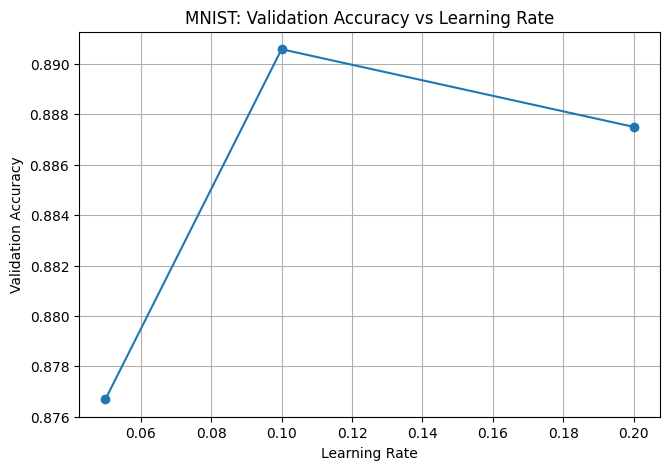

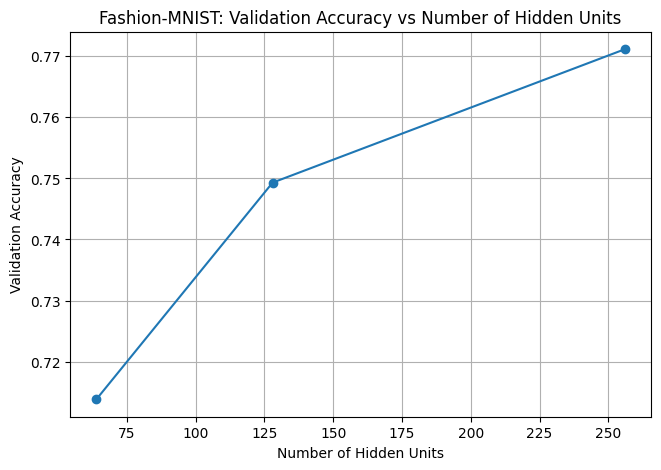

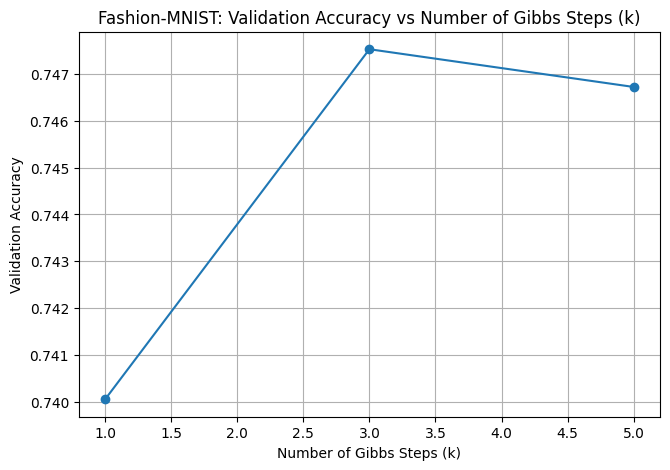

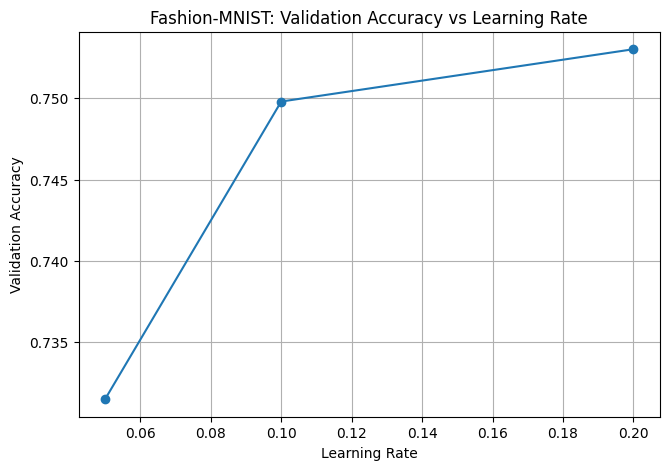

In [ ]:
def plot_factor(df, dataset_name, factor, metric="val_acc", x_label=None, y_label=None):
    agg = (df[df["dataset"] == dataset_name]
           .groupby(factor)[metric]
           .mean()
           .reset_index()
           .sort_values(factor))

    plt.figure()
    plt.plot(agg[factor].astype(float), agg[metric], marker="o")
    plt.xlabel(x_label if x_label else factor)
    plt.ylabel(y_label if y_label else metric)
    plt.title(f"{dataset_name}: {y_label if y_label else metric} vs {x_label if x_label else factor}")
    plt.show()


plot_factor(df_results, "MNIST", "n_hidden", metric="val_acc",
            x_label="Number of Hidden Units", y_label="Validation Accuracy")

plot_factor(df_results, "MNIST", "k", metric="val_acc",
            x_label="Number of Gibbs Steps (k)", y_label="Validation Accuracy")

plot_factor(df_results, "MNIST", "lr", metric="val_acc",
            x_label="Learning Rate", y_label="Validation Accuracy")

plot_factor(df_results, "Fashion-MNIST", "n_hidden", metric="val_acc",
            x_label="Number of Hidden Units", y_label="Validation Accuracy")

plot_factor(df_results, "Fashion-MNIST", "k", metric="val_acc",
            x_label="Number of Gibbs Steps (k)", y_label="Validation Accuracy")

plot_factor(df_results, "Fashion-MNIST", "lr", metric="val_acc",
            x_label="Learning Rate", y_label="Validation Accuracy")



## Inspect the best model per dataset

Model performance and confusion matrix for the validation set


              precision    recall  f1-score   support

           0     0.9305    0.9724    0.9510       399
           1     0.9248    0.9715    0.9476       456
           2     0.9062    0.8756    0.8906       386
           3     0.9070    0.8699    0.8881       415
           4     0.9273    0.9177    0.9225       389
           5     0.9164    0.8958    0.9060       355
           6     0.9246    0.9340    0.9293       394
           7     0.9356    0.9356    0.9356       419
           8     0.8685    0.9115    0.8895       384
           9     0.9239    0.8734    0.8980       403

    accuracy                         0.9167      4000
   macro avg     0.9165    0.9157    0.9158      4000
weighted avg     0.9168    0.9167    0.9165      4000



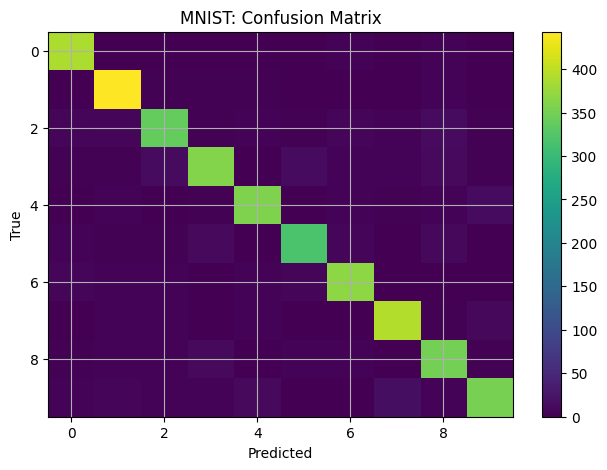

              precision    recall  f1-score   support

           0     0.7479    0.6822    0.7135       387
           1     0.9766    0.9259    0.9506       405
           2     0.6835    0.6162    0.6481       396
           3     0.7652    0.8433    0.8024       402
           4     0.6842    0.6285    0.6552       393
           5     0.8635    0.7711    0.8147       402
           6     0.4254    0.5097    0.4637       414
           7     0.8188    0.8903    0.8530       401
           8     0.8701    0.9010    0.8853       394
           9     0.9231    0.9163    0.9197       406

    accuracy                         0.7685      4000
   macro avg     0.7758    0.7684    0.7706      4000
weighted avg     0.7753    0.7685    0.7704      4000



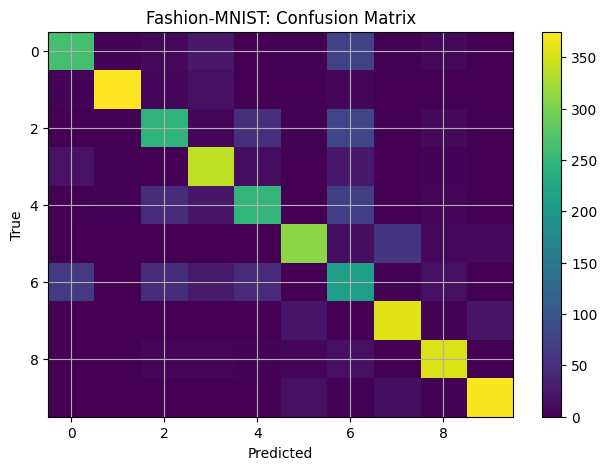

In [ ]:

def evaluate_best_model(dataset_name, fashion, best_cfg, n_samples=20000, test_size=0.2):
    X, y = load_dataset(fashion=fashion)
    X = X[:n_samples]
    y = y[:n_samples].astype(int)
    X = _binarize(X, threshold=0.5)
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    y1_tr = _one_hot(y_tr, 10)

    cfg = RBMConfig(n_visible=784+10, **{k:v for k,v in best_cfg.items() if k != "n_visible"})
    rbm = RBM(cfg)
    rbm.fit(X_tr, y_tr, y1_tr, epochs=cfg.epochs, verbose=False)
    y_pred = rbm.predict_labels(X_val)

    print(classification_report(y_val, y_pred, digits=4))
    cm = confusion_matrix(y_val, y_pred)
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(f"{dataset_name}: Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()


best_cfg_mnist, best_rbm_mnist, best_acc_mnist = best_models["MNIST"]
evaluate_best_model("MNIST", False, best_cfg_mnist, n_samples=20000, test_size=0.2)

best_cfg_fashion, best_rbm_fashion, best_acc_fashion = best_models["Fashion-MNIST"]
evaluate_best_model("Fashion-MNIST", True, best_cfg_fashion, n_samples=20000, test_size=0.2)


Reconstruction demonstration for the trained best models

In [ ]:
def reconstruct_samples(rbm, n=10, fashion=False, n_data=20000, seed=42):
    np.random.seed(seed)

    X, y = load_dataset(fashion=fashion)
    X, y = X[:n_data], y[:n_data].astype(int)

    X_bin = _binarize(X)
    y_oh = _one_hot(y, 10)

    X_rbm = np.hstack([X_bin, y_oh]).astype(np.float32)

    idx = np.random.choice(X_rbm.shape[0], n, replace=False)
    X_samples = X_rbm[idx]

    h_prob = rbm._p_h_given_v(X_samples)
    h_sample = rbm._sample_bernoulli(h_prob)

    v_prob = rbm._p_v_given_h(h_sample)
    v_sample = (v_prob > 0.5).astype(np.float32)

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(X_samples[i, :-10].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Original", fontsize=12)

        plt.subplot(2, n, n+i+1)
        plt.imshow(v_sample[i, :-10].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Reconstructed", fontsize=12)

    dataset_name = "Fashion-MNIST" if fashion else "MNIST"
    plt.suptitle(f"{dataset_name}: RBM Reconstructions", fontsize=16)
    plt.show()


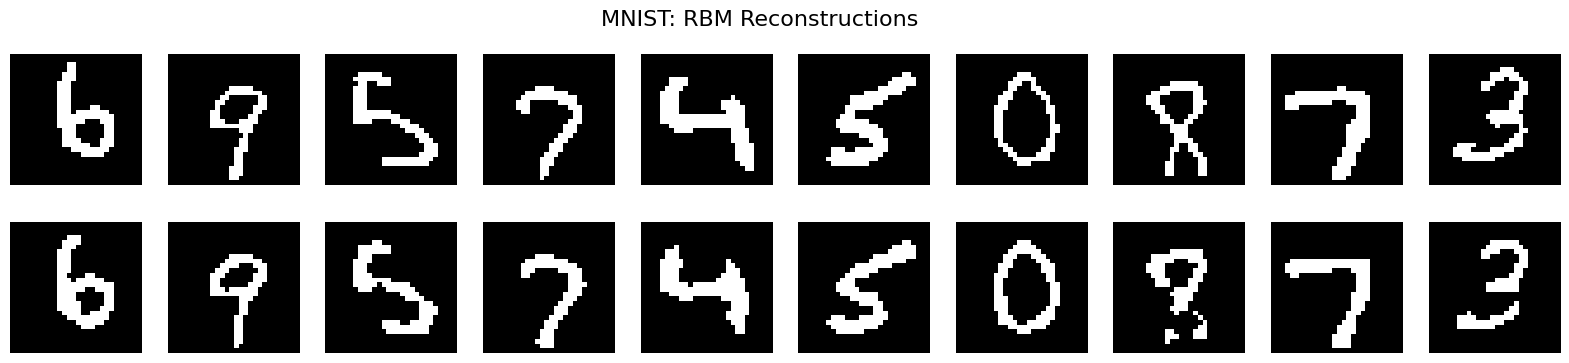

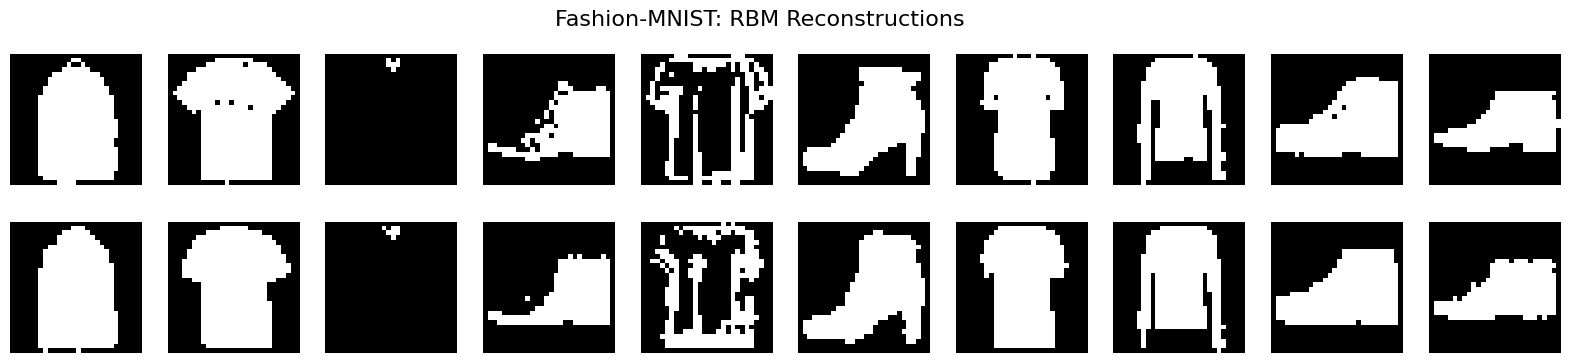

In [ ]:
# MNIST reconstruction
reconstruct_samples(best_rbm_mnist, n=10, fashion=False)

# Fashion-MNIST reconstruction
reconstruct_samples(best_rbm_fashion, n=10, fashion=True)

Loading model from Drive

Model loaded from Drive: <__main__.RBM object at 0x7c767010baa0>


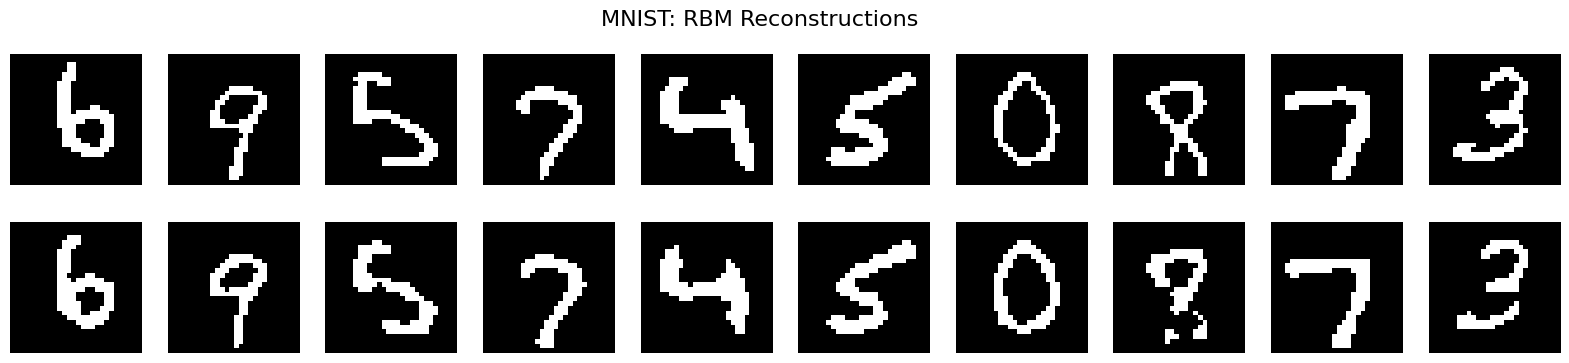

Model loaded from Drive: <__main__.RBM object at 0x7c7672941430>


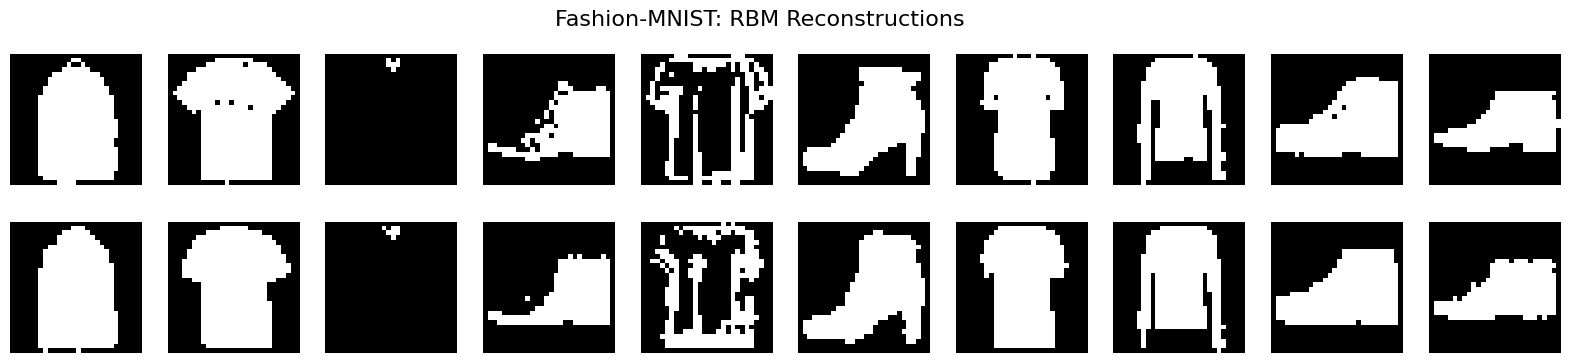

In [ ]:
name = ["mnist", "fashion"]
loaded_rbms = {}
for nam in name:
  load_path = f"/content/drive/MyDrive/rbm_{nam}.pkl"
  with open(load_path, "rb") as f:
      loaded_rbms[nam] = pickle.load(f)

  print("Model loaded from Drive:", loaded_rbms[nam])
  if nam == "fashion":
    fashion = True
  else:
    fashion = False
  reconstruct_samples(loaded_rbms[nam], n=10, fashion=fashion)


Classify (digits) through image uploads
Fashion is possible but harder to draw

In [ ]:
from google.colab import files
from PIL import Image

uploaded = files.upload()

for filename in uploaded:
    img = Image.open(filename).convert("L")

    img = img.resize((28, 28))

    img_array = np.array(img).astype(np.float32)/255.0

    img_bin = _binarize(img_array.flatten()[None, :])

    dummy_label = np.zeros((1,10), dtype=np.float32)
    # X_rbm = np.hstack([img_bin, dummy_label])

    try:
      rbm = best_rbm_mnist
    except NameError:
      rbm = loaded_rbms["mnist"]

    # pred = rbm.predict_labels(X_rbm)[0]
    pred = rbm.predict_labels(img_bin)[0]

    print(f"Predicted class: {pred}")

    plt.imshow(img_array, cmap='gray')
    plt.title(f"Uploaded Image (Predicted: {pred})")
    plt.axis('off')
    plt.show()


KeyboardInterrupt: 